# Exploring time dimension
Misinformation spreads faster than legit information. We can measure the intervals from the shares of the same message and use this pattern to classify it. However, this may be limited by the incompletude of the sample. Another limitation is that it may be necessary a minimum number of shares for a distinguishible pattern arise

We are inspired by this work: 
### Fake news propagates differently from real news even at early stages of spreading
https://epjds.epj.org/articles/epjdata/abs/2020/01/13688_2020_Article_224/13688_2020_Article_224.html

https://www.researchgate.net/publication/280929880_Detect_Rumors_Using_Time_Series_of_Social_Context_Information_on_Microblogging_Websites

Additionaly, we explore and visualize the spread time of misinformation in whatsapp



In [79]:
import pandas as pd
from utils import preprocess
from sklearn.linear_model import LogisticRegression
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

# Load data

In [13]:
# train-test sets
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')



# full labelled data
df_full = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
print(df_full.columns)
df_full = df_full[df_full['midia']==0]
df_full = df_full[df_full['misinformation']!=-1]
df_full['timestamp'] = df_full.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df_full['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df_full.sort_values(by='timestamp',inplace=True)
df_full = df_full[['id','timestamp','text', 'misinformation']]
print(len(df_full))
df_full.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'date', 'hour', 'ddi', 'country', 'country_iso3', 'ddd', 'state',
       'group', 'midia', 'url', 'characters', 'words', 'viral', 'shares',
       'text', 'misinformation'],
      dtype='object')
23660


,id,timestamp,text,misinformation
45586,6942577183305588053,2018-07-02 10:46:00,"O dia em que ex-guerrilheiro, militantes e des...",1
54063,-2072140886659020977,2018-07-02 10:50:00,O nível dos jornalistas do programa Roda Viva ...,1
254245,-5100443702615645928,2018-07-02 11:03:00,*Atenção*\n\nPrecisamos da ajuda de todos você...,0
233101,-1561843698204261697,2018-07-02 16:31:00,"Gestão do colombiano na capital, imagina ele n...",1
159004,-1561843698204261697,2018-07-02 16:32:00,"Gestão do colombiano na capital, imagina ele n...",1


In [ ]:
df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]

# Calculate time intervals between appearences of messages

In [51]:

def get_time_deltas(df_target, k):
    for m_id in set(df_target['id_message']):
        messages_variations = []
        messages = df_target[df_target['id_message']==m_id]['text']

        for m in messages:
            messages_variations.append(df_full[df_full['text']==m])

        df_message_variations = pd.concat(messages_variations)
        df_message_variations.sort_values(by='timestamp', inplace = True)
        df_message_variations.sort_values(by='timestamp', inplace = True)

        timestamps = list(df_message_variations['timestamp'])
        deltas = []
        for i in range(len(timestamps)-1):
            # time delta in minutes
            delta = (timestamps[i+1]-timestamps[i]).total_seconds()/60
            deltas.append(delta)

        deltas = deltas[0:k]
        # get k time deltas. if there is not enought shares, pad with -1
        if len(deltas) < k:
            deltas += [-1]*(k - len(deltas))    

        message_id_2_deltas[m_id] = deltas

    k_timedeltas = [[] for i in range(k)]

    for m_id in df_target['id_message']:
        timedeltas = message_id_2_deltas[m_id]
        for i, td in enumerate(timedeltas):
            k_timedeltas[i].append(td)

    for i, timefeature in enumerate(k_timedeltas):
        col_name = 't'+str(i)
        df_target[col_name] = timefeature
    
    return df_target



In [69]:
K = 10
df_train = get_time_deltas(df_train, K)
df_test = get_time_deltas(df_test, K)

In [233]:
df_test

,text,misinformation,original,id_message,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,preprocessed_text
0,Líder PCC preso em São Paulo ontem externa tod...,1,1,3304,4420.0,1251.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,lider pcc presar paulo ontem externo todo ousa...
1,"🗣 Amanhã, as 10:00 hs, na praça da Matriz, um ...",1,1,3305,1440.0,847.0,593.0,2525.0,660.0,59.0,-1.0,-1.0,-1.0,-1.0,amanha hs praca matriz monge estar benzer pes...
2,Saiu pesquisa para presidente 2018 encomendad...,1,1,3306,557.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,sair pesquisarr presidente encomendar pea reda...
3,Marina sofre atentado em campanha e é internad...,0,1,3307,22.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,marino sofrer atentar campanha internar pressa...
4,UOL (@UOL) tweetou: PT nas eleições | Ciro vai...,0,1,3308,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,uol uol tweetou pt eleicao ciro ir gravar vide...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,*https://youtu.be/sUGeHHOEqmQ. ...,1,1,4126,4318.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,youtube colocar video alto assistir divulgar !...
1570,AGORA A BOMBA CAI NO COLO DE CINTHIA RIBEIRO: ...,0,1,4127,10080.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,agora bomba cair colar cinthia ribeiro acordar...
1571,"OS TRAIDORES DA IGREJA. PADRES COMUNISTAS, ETC...",1,1,4128,29.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,traidor igreja padre comunista etc ai dar pros...
1572,"Desmascarando, a pesquisa publicada na rede Gl...",1,1,4129,3027.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,desmascarar pesquisar publicar redar globo pas...


# Analysis

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


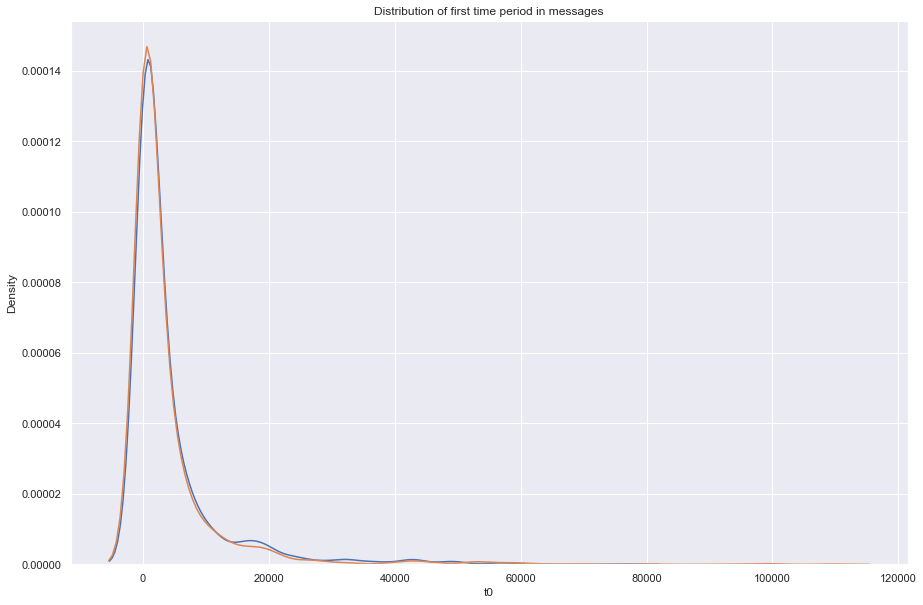

In [228]:
df_time = pd.concat([df_train,df_test])
df_time = df_time[df_time['original']==1]
df_time['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df_time['misinformation']]
plt.figure(figsize=(15,10))
plt.title('Distribution of first time period in messages')
sns.distplot(df_time[df_time['label']=='misinformation']['t0'], hist=False, rug=False)
sns.distplot(df_time[df_time['label']=='non-misinformation']['t0'], hist=False, rug=False)
plt.show()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


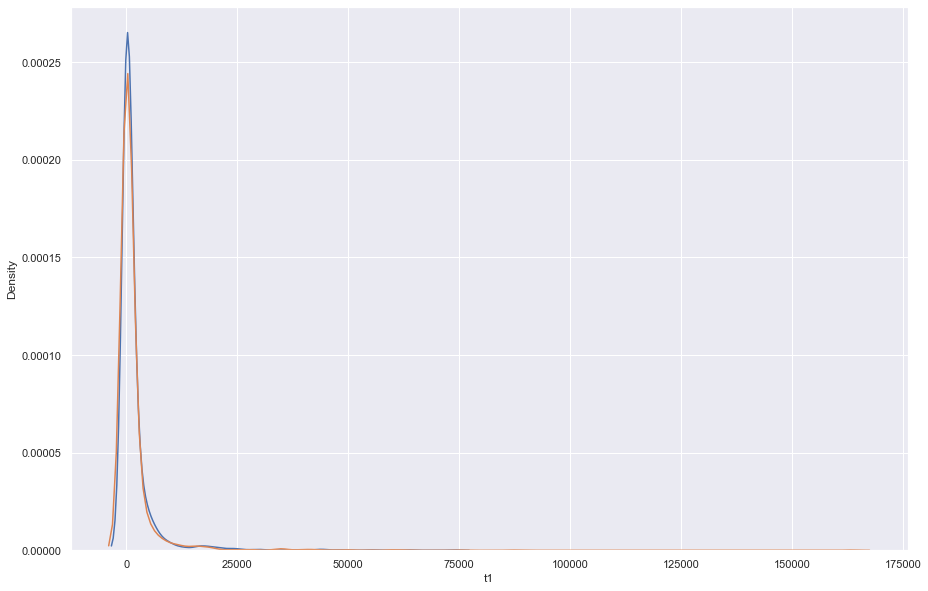

In [229]:
df_time = pd.concat([df_train,df_test])
df_time = df_time[df_time['original']==1]
df_time['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df_time['misinformation']]
plt.figure(figsize=(15,10))
sns.distplot(df_time[df_time['label']=='misinformation']['t1'], hist=False, rug=False)
sns.distplot(df_time[df_time['label']=='non-misinformation']['t1'], hist=False, rug=False)
plt.show()

# Classification

In [322]:
k = 5
first_share = -K-1
last_share = first_share + k
df_train[df_train.columns[first_share:last_share]].describe()

,t0,t1,t2,t3,t4
count,6233.000000,6233.00000,6233.000000,6233.000000,6233.000000
mean,4789.224130,2286.77956,1414.704637,1232.653618,946.007541
std,8809.335989,5799.57016,4671.185549,3823.737519,3859.312511
min,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000
25%,91.000000,0.00000,-1.000000,-1.000000,-1.000000
50%,1439.000000,355.00000,64.000000,31.000000,1.000000
75%,4945.000000,1847.00000,1107.000000,927.000000,427.000000
max,109968.000000,87248.00000,85527.000000,59134.000000,76512.000000


In [323]:
X_train = df_train[df_train.columns[first_share:last_share]].to_numpy()
X_test = df_test[df_test.columns[first_share:last_share]].to_numpy()
y_train = df_train['misinformation']
y_test = df_test['misinformation']

X_train, X_test = utils.z_score(X_train,X_test)

X_train.shape

(6233, 5)

logistic regression + time
0.47
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       834
           1       0.55      0.47      0.51       740

    accuracy                           0.57      1574
   macro avg       0.57      0.57      0.56      1574
weighted avg       0.57      0.57      0.57      1574

AUC:  0.5813160282584743


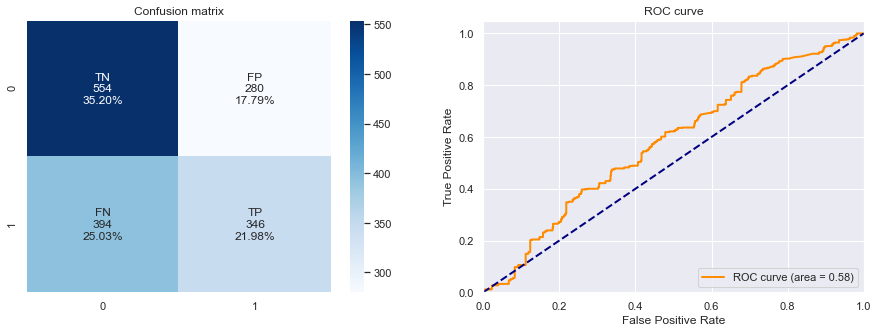

0,571
0,378
0,552
0,467
0,506
0,581


(0.5717916137229987,
 0.37822671156004495,
 0.5527156549520766,
 0.46756756756756757,
 0.5065885797950219,
 0.5813160282584743)

In [324]:
print('logistic regression + time')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + time
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.623
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.521
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.670
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.607
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.686

--------------------
BEST PARAMETERS (validation AUC = 0.686)
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
--------------------
0.5
              precision    recall  f1-score   support

           0       0.58      0.65      0.61       834
           1       0.54      0.46      0.50       740

    accuracy                           0.56      1574
   macro avg       0.56      0.56      0.55      1574
weighted avg       0.56      0.56      0.56      1574

AUC:  0.5909294186272604


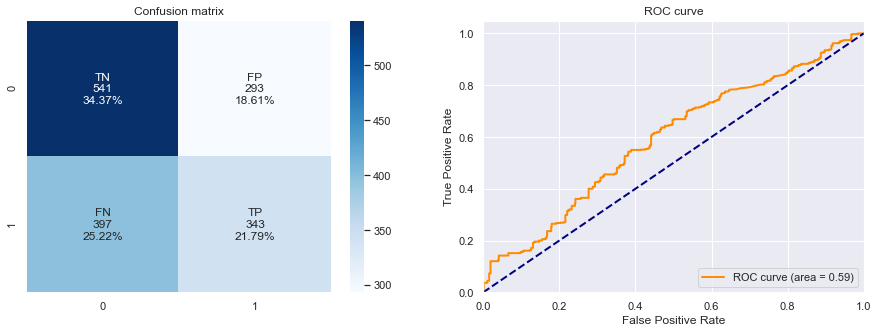

0,561
0,389
0,539
0,463
0,498
0,590


(0.5616264294790343,
 0.3893905191873589,
 0.539308176100629,
 0.4635135135135135,
 0.498546511627907,
 0.5909294186272604)

In [326]:
print('mlp + time')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combine 3 dimensions features

In [175]:
y_train = df_train['misinformation']
y_test = df_test['misinformation']

### Time

In [304]:
k = 5
first_share = -K
last_share = first_share + k
X_train_time = df_train[df_train.columns[first_share:last_share]].to_numpy()
X_test_time = df_test[df_test.columns[first_share:last_share]].to_numpy()
print(X_train_time.shape)
# 
X_train_time, X_test_time = utils.z_score(X_train_time, X_test_time)

# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train_time)
# X_train_time = scaler.transform(X_train_time)
# X_test_time = scaler.transform(X_test_time)

(6233, 5)


### Social

In [305]:
with open('train_user_features.npy', 'rb') as f:
    train_u = np.load(f)

with open('test_user_features.npy', 'rb') as f:
    test_u = np.load(f)
train_u.shape

(6233, 2)

### Content

In [317]:
tfidf = TfidfVectorizer(max_features = 15000, ngram_range = (1,1), binary= True, token_pattern = r'[^\s]+')  #token_pattern = r'[^\s]+',

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
print(X_train_tfidf.shape)
X_train[0]

(6233, 15000)


matrix([[ 0.02645857,  0.        ,  0.        , ..., -0.17985251,
          0.15677429,  0.29860159]])

### Concatenate

In [318]:
X_train = np.concatenate((X_train_tfidf, train_u, X_train_time), axis=1)
X_test = np.concatenate((X_test_tfidf, test_u, X_test_time), axis=1)
X_train.shape

(6233, 15007)

In [319]:
#X_train, X_test = utils.z_score(X_train, X_test)
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

logistic regression + tf-idf + user + time


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.49
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       834
           1       0.82      0.80      0.81       740

    accuracy                           0.82      1574
   macro avg       0.82      0.82      0.82      1574
weighted avg       0.82      0.82      0.82      1574

AUC:  0.8992433080562577


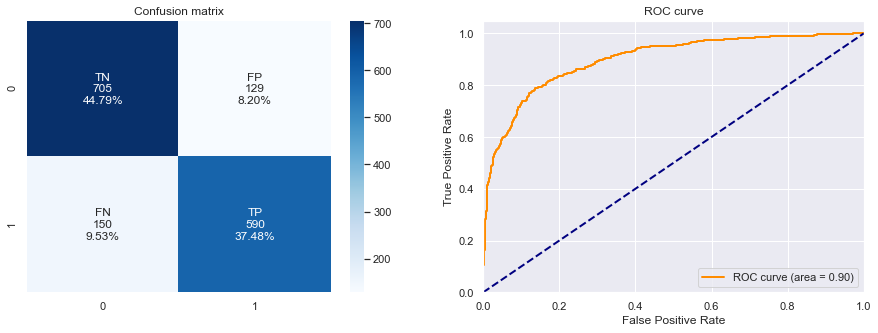

0,822
0,165
0,820
0,797
0,808
0,899


(0.8227445997458704,
 0.1651865008880995,
 0.8205841446453408,
 0.7972972972972973,
 0.8087731322823851,
 0.8992433080562577)

In [320]:
print('logistic regression + tf-idf + user + time')
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + tf-idf + user + time
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.888
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.880
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.902
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.888
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.888

--------------------
BEST PARAMETERS (validation AUC = 0.902)
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
--------------------
0.5
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       834
           1       0.79      0.77      0.78       740

    accuracy                           0.79      1574
   macro avg       0.79      0.79      0.79      1574
weighted avg       0.79      0.79      0.79      1574

AUC:  0.86448246807

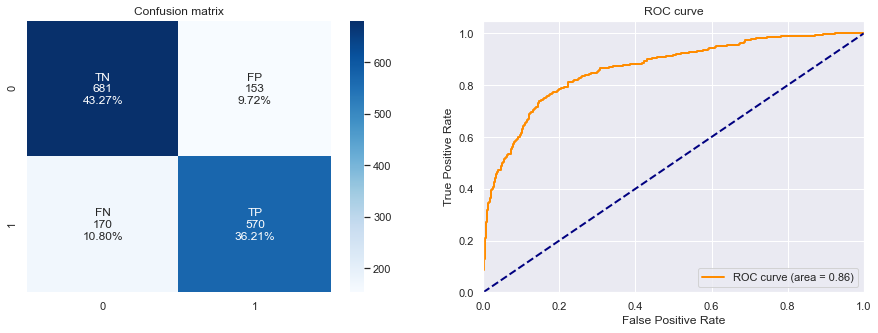

0,794
0,191
0,788
0,770
0,779
0,864


(0.7947903430749682,
 0.19169139465875362,
 0.7883817427385892,
 0.7702702702702703,
 0.7792207792207793,
 0.8644824680795904)

In [321]:
print('mlp + tf-idf + user + time')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)